In [ ]:
# Install necessary libraries
!pip install "numpy<2" ultralytics scikit-learn opencv-python pandas tqdm pyyaml matplotlib kagglehub roboflow

In [8]:
import os
import glob
import shutil
import yaml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import json

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Preparation

This section merges the annotated dataset with the raw Calculus and Hypodontia datasets, performs a stratified split, and organizes them into the YOLO directory structure.

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="Fi3Sh8fR3JkMox96bMBc")
project = rf.workspace("segp-fcn6m").project("oral-diseases-5ctay-h9oye")
version = project.version(1)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to oral-diseases-1 in yolov8:: 100%|██████████| 20012/20012 [00:20<00:00, 981.99it/s] 


In [4]:
# Configuration
WORKSPACE_DIR = os.getcwd()
DATASET_ROOT = os.path.join(WORKSPACE_DIR, "datasets", "salmansajid05", "oral-diseases", "versions", "3")
OUTPUT_DIR = os.path.join(WORKSPACE_DIR, "dataset_yolo")

# Source Paths
ANNOTATED_DIR = os.path.join(DATASET_ROOT, "Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset", "Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset", "Data")
CALCULUS_DIR = os.path.join(DATASET_ROOT, "Calculus", "Calculus")
HYPODONTIA_DIR = os.path.join(DATASET_ROOT, "hypodontia", "hypodontia")

# Target Classes
TARGET_CLASSES = ['Caries', 'Calculus', 'Gingivitis', 'Tooth Discoloration', 'Ulcers', 'Hypodontia']

# Mapping from Annotated Dataset (Source) to Target
MAPPING = {
    0: 0, # Caries -> Caries
    1: 4, # Ulcer -> Ulcers
    2: 3, # Tooth Discoloration -> Tooth Discoloration
    3: 2  # Gingivitis -> Gingivitis
}

def get_image_files(directory):
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
    files = []
    for ext in extensions:
        files.extend(glob.glob(os.path.join(directory, ext)))
    return files

def prepare_dataset():
    print("Starting Data Preparation...")
    
    data_samples = []

    # 1. Process Annotated Dataset
    if os.path.exists(ANNOTATED_DIR):
        for split in ['train', 'val']:
            img_dir = os.path.join(ANNOTATED_DIR, "images", split)
            lbl_dir = os.path.join(ANNOTATED_DIR, "labels", split)
            
            img_files = get_image_files(img_dir)
            for img_path in img_files:
                basename = os.path.splitext(os.path.basename(img_path))[0]
                lbl_path = os.path.join(lbl_dir, basename + ".txt")
                
                if os.path.exists(lbl_path):
                    stratify_cls = None
                    with open(lbl_path, 'r') as f:
                        for line in f:
                            try:
                                parts = line.split()
                                if not parts: continue
                                cls = int(parts[0])
                                if cls in MAPPING:
                                    stratify_cls = MAPPING[cls]
                                    break
                            except ValueError:
                                continue
                    
                    # Only include if we found a valid class for stratification
                    if stratify_cls is not None:
                        data_samples.append({
                            'image_path': img_path,
                            'label_path': lbl_path,
                            'source': 'annotated',
                            'stratify_cls': stratify_cls
                        })
    else:
        print(f"Warning: Annotated directory not found at {ANNOTATED_DIR}")

    # 2. Process Calculus (Raw)
    if os.path.exists(CALCULUS_DIR):
        calc_files = get_image_files(CALCULUS_DIR)
        print(f"Found {len(calc_files)} Calculus images")
        for img_path in calc_files:
            data_samples.append({
                'image_path': img_path,
                'label_path': None,
                'source': 'calculus',
                'stratify_cls': 1
            })
    else:
        print(f"Warning: Calculus directory not found at {CALCULUS_DIR}")

    # 3. Process Hypodontia (Raw)
    if os.path.exists(HYPODONTIA_DIR):
        hypo_files = get_image_files(HYPODONTIA_DIR)
        print(f"Found {len(hypo_files)} Hypodontia images")
        for img_path in hypo_files:
            data_samples.append({
                'image_path': img_path,
                'label_path': None,
                'source': 'hypodontia',
                'stratify_cls': 5
            })
    else:
        print(f"Warning: Hypodontia directory not found at {HYPODONTIA_DIR}")

    if not data_samples:
        print("Error: No data found.")
        return

    df = pd.DataFrame(data_samples)
    print(f"Total samples found: {len(df)}")

    # 4. Stratified Split Validation
    class_counts = df['stratify_cls'].value_counts()
    print("Class distribution before split:")
    print(class_counts)
    
    valid_classes = class_counts[class_counts >= 2].index
    df_filtered = df[df['stratify_cls'].isin(valid_classes)].copy()
    
    if len(df_filtered) < len(df):
        print(f"Warning: Dropped {len(df) - len(df_filtered)} samples due to insufficient class representation (<2 samples).")
    
    if len(df_filtered) == 0:
        print("Error: No valid data left after filtering.")
        return

    # 5. Perform Split
    train_df, temp_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['stratify_cls'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['stratify_cls'], random_state=42)

    print(f"Split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

    # 6. Organize Files
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    
    splits = {'train': train_df, 'val': val_df, 'test': test_df}
    
    for split_name, split_df in splits.items():
        os.makedirs(os.path.join(OUTPUT_DIR, "images", split_name), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_DIR, "labels", split_name), exist_ok=True)
        
        for _, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"Processing {split_name}"):
            src_img = row['image_path']
            filename = f"{row['source']}_{os.path.basename(src_img)}"
            dst_img = os.path.join(OUTPUT_DIR, "images", split_name, filename)
            dst_lbl = os.path.join(OUTPUT_DIR, "labels", split_name, os.path.splitext(filename)[0] + ".txt")
            
            shutil.copy2(src_img, dst_img)
            
            if row['source'] == 'annotated':
                with open(row['label_path'], 'r') as f_in, open(dst_lbl, 'w') as f_out:
                    for line in f_in:
                        parts = line.split()
                        if not parts: continue
                        try:
                            cls_id = int(parts[0])
                            if cls_id in MAPPING:
                                f_out.write(f"{MAPPING[cls_id]} {' '.join(parts[1:])}\n")
                        except ValueError:
                            continue
            else:
                cls = 1 if row['source'] == 'calculus' else 5
                with open(dst_lbl, 'w') as f:
                    f.write(f"{cls} 0.5 0.5 1.0 1.0\n")

    # 7. Create data.yaml
    # Use forward slashes for paths to avoid YAML/YOLO issues on Windows
    yaml_content = {
        'path': OUTPUT_DIR.replace('\\', '/'),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'names': {i: name for i, name in enumerate(TARGET_CLASSES)}
    }
    
    with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)
    
    print("Data preparation complete.")

# Run the preparation
# prepare_dataset() # Skipped as we are using pre-prepared 'oral-diseases-1' dataset

Starting Data Preparation...
Error: No data found.


## 2. Model Training (Yolov8m)


In [9]:
def train_model():
    # Debugging: Print current directory to understand where we are running
    cwd = os.getcwd()
    print(f"Current Working Directory: {cwd}")

    # Try to find the dataset in common locations
    # 1. Current directory (Ideal)
    # 2. Backend Development/Model B (If running from Home on HPC)
    # 3. Model B (If running from project root)
    possible_paths = [
        os.path.join(cwd, 'oral-diseases-1'),
        os.path.join(cwd, 'Backend Development', 'Model B', 'oral-diseases-1'),
        os.path.join(cwd, 'Model B', 'oral-diseases-1')
    ]

    dataset_dir = None
    for path in possible_paths:
        if os.path.exists(os.path.join(path, 'data.yaml')):
            dataset_dir = path
            break
    
    if dataset_dir is None:
        print(f"❌ Dataset configuration not found!")
        print(f"Checked paths: {possible_paths}")
        print("Please ensure the 'oral-diseases-1' folder exists.")
        return

    yaml_path = os.path.join(dataset_dir, 'data.yaml')
    print(f"✅ Found dataset at: {dataset_dir}")

    # Fix data.yaml paths to be absolute (Critical for HPC/Cross-platform)
    print(f"Fixing paths in {yaml_path}...")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Update paths to be absolute based on the actual dataset location
    data_config['train'] = os.path.join(dataset_dir, 'train', 'images')
    data_config['val'] = os.path.join(dataset_dir, 'valid', 'images')
    data_config['test'] = os.path.join(dataset_dir, 'test', 'images')
    
    with open(yaml_path, 'w') as f:
        yaml.dump(data_config, f)
        
    # Load a pretrained model
    model = YOLO('models/best.pt')

    # Check for GPU
    import torch
    if torch.cuda.is_available():
        print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
        device = 0
        batch_size = -1 # AutoBatch
    else:
        print("⚠️ No GPU detected. Training will be slow on CPU.")
        device = 'cpu'
        batch_size = 16

    # Determine workers based on OS
    workers = 0 if os.name == 'nt' else 8

    # Train
    print(f"Starting training with dataset: {yaml_path}")
    results = model.train(
        data=yaml_path,
        epochs=100,
        patience=10,
        imgsz=640,
        batch=batch_size,
        device=device,
        degrees=0.0,      # Disable rotation
        shear=0.0,        # Disable shear
        flipud=0.0,       # Disable vertical flip
        fliplr=0.5,       # Horizontal flip is okay
        mosaic=1.0,       # Keep mosaic
        project='oral_cancer_screening',
        name='yolov8m_run',
        exist_ok=True,
        workers=workers
    )
    print("Training complete.")

# Start training
train_model()

Current Working Directory: c:\Users\user\Desktop\SEGP\Oral-Health-Computer-Vision-Model\Model B
✅ Found dataset at: c:\Users\user\Desktop\SEGP\Oral-Health-Computer-Vision-Model\Model B\oral-diseases-1
Fixing paths in c:\Users\user\Desktop\SEGP\Oral-Health-Computer-Vision-Model\Model B\oral-diseases-1\data.yaml...
✅ GPU Detected: NVIDIA GeForce RTX 4050 Laptop GPU
Starting training with dataset: c:\Users\user\Desktop\SEGP\Oral-Health-Computer-Vision-Model\Model B\oral-diseases-1\data.yaml
New https://pypi.org/project/ultralytics/8.3.235 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.231  Python-3.12.7 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\user\Desktop\SEGP\

OSError: [Errno 22] Invalid argument

## 3. Inference Class

This class encapsulates the model and provides the business logic for screening results and hygiene scores.

In [16]:
class OralHygieneModel:
    def __init__(self, model_path):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at {model_path}")
        self.model = YOLO(model_path)
        self.class_names = {
            0: 'Caries',
            1: 'Calculus',
            2: 'Gingivitis',
            3: 'Tooth Discoloration',
            4: 'Ulcers',
            5: 'Hypodontia'
        }

    def predict(self, image_path):
        if not os.path.exists(image_path):
            return {"error": "Image file not found"}

        # Run inference
        try:
            # Increased confidence to 0.50 to match production settings
            # verbose=False suppresses the "image 1/1..." output
            results = self.model.predict(image_path, conf=0.50, save=False, verbose=False)
            if not results:
                return {"error": "No results returned from model"}
            
            result = results[0]

            detections = []
            findings = set()
            counts = {name: 0 for name in self.class_names.values()}

            for box in result.boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                bbox = box.xyxy[0].tolist()
                
                class_name = self.class_names.get(cls_id, "Unknown")
                findings.add(class_name)
                counts[class_name] = counts.get(class_name, 0) + 1

                detections.append({
                    "class": class_name,
                    "confidence": round(conf, 2),
                    "bbox": [round(x, 2) for x in bbox]
                })

            # Logic for Screening Result
            screening_result = "Normal"
            if "Ulcers" in findings:
                screening_result = "Refer to Doctor"

            # Logic for Hygiene Score
            hygiene_issues_count = counts.get('Calculus', 0) + counts.get('Gingivitis', 0)
            
            if hygiene_issues_count > 2:
                hygiene_score = "Low"
            elif hygiene_issues_count > 0:
                hygiene_score = "Medium"
            else:
                hygiene_score = "High"

            return {
                "screening_result": screening_result,
                "findings": list(findings),
                "hygiene_score": hygiene_score,
                "detections": detections
            }
        except Exception as e:
            return {"error": str(e)}

## 4. Validation & Visualization

We will now load the trained model and visualize predictions on a few test images.

Loading model from oral_cancer_screening\yolov8m_run\weights\best.pt...

Image: hypodontia_(776).jpg
{
  "screening_result": "Normal",
  "findings": [
    "Hypodontia"
  ],
  "hygiene_score": "High",
  "detections": [
    {
      "class": "Hypodontia",
      "confidence": 0.98,
      "bbox": [
        0.0,
        0.64,
        611.8,
        363.0
      ]
    }
  ]
}

Image: hypodontia_(776).jpg
{
  "screening_result": "Normal",
  "findings": [
    "Hypodontia"
  ],
  "hygiene_score": "High",
  "detections": [
    {
      "class": "Hypodontia",
      "confidence": 0.98,
      "bbox": [
        0.0,
        0.64,
        611.8,
        363.0
      ]
    }
  ]
}


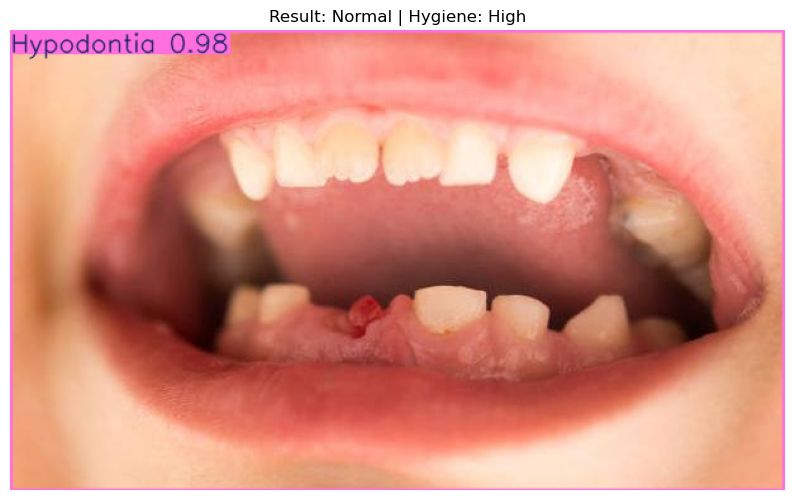


Image: hypodontia_(1004).JPG
{
  "screening_result": "Normal",
  "findings": [
    "Hypodontia"
  ],
  "hygiene_score": "High",
  "detections": [
    {
      "class": "Hypodontia",
      "confidence": 0.99,
      "bbox": [
        0.0,
        0.0,
        282.67,
        131.53
      ]
    }
  ]
}


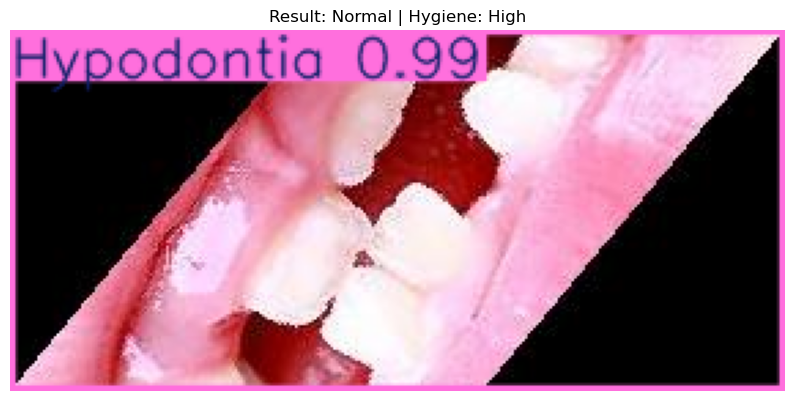


Image: calculus_(245).jpg
{
  "screening_result": "Normal",
  "findings": [
    "Calculus"
  ],
  "hygiene_score": "Medium",
  "detections": [
    {
      "class": "Calculus",
      "confidence": 0.99,
      "bbox": [
        0.0,
        0.64,
        611.83,
        409.0
      ]
    }
  ]
}


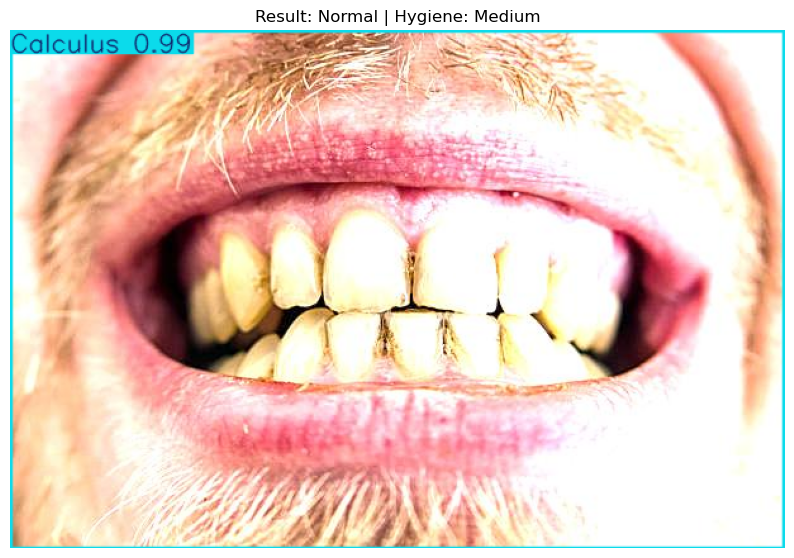


Image: hypodontia_(58).JPG
{
  "screening_result": "Normal",
  "findings": [
    "Hypodontia"
  ],
  "hygiene_score": "High",
  "detections": [
    {
      "class": "Hypodontia",
      "confidence": 0.98,
      "bbox": [
        0.0,
        0.18,
        294.65,
        111.0
      ]
    }
  ]
}


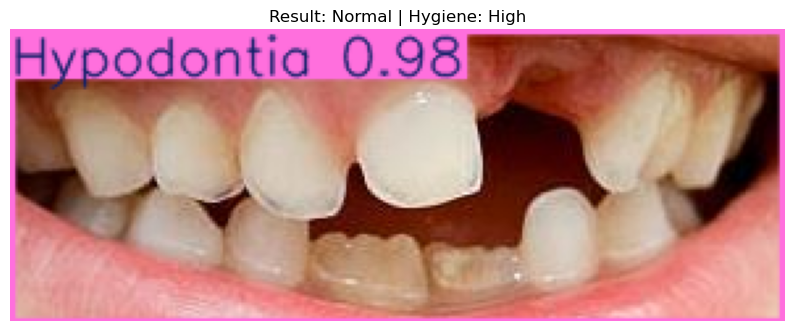


Image: hypodontia_(27).JPG
{
  "screening_result": "Normal",
  "findings": [
    "Hypodontia"
  ],
  "hygiene_score": "High",
  "detections": [
    {
      "class": "Hypodontia",
      "confidence": 0.98,
      "bbox": [
        0.29,
        0.06,
        286.62,
        61.73
      ]
    }
  ]
}

{
  "screening_result": "Normal",
  "findings": [
    "Hypodontia"
  ],
  "hygiene_score": "High",
  "detections": [
    {
      "class": "Hypodontia",
      "confidence": 0.98,
      "bbox": [
        0.29,
        0.06,
        286.62,
        61.73
      ]
    }
  ]
}


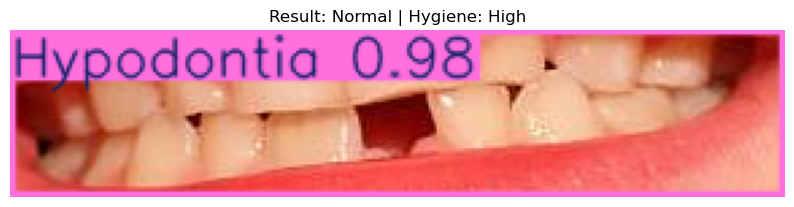

In [18]:
def visualize_results(num_images=5):
    # Path where YOLO saves the best model
    model_path = os.path.join("oral_cancer_screening", "yolov8m_run", "weights", "best.pt")
    test_dir = os.path.join(OUTPUT_DIR, "images", "test")
    
    if not os.path.exists(model_path):
        print(f"Model weights not found at {model_path}. Did training finish successfully?")
        return

    print(f"Loading model from {model_path}...")
    try:
        hygiene_model = OralHygieneModel(model_path)
    except Exception as e:
        print(f"Failed to load model: {e}")
        return
    
    # Get test images
    image_files = glob.glob(os.path.join(test_dir, "*.jpg")) + \
                  glob.glob(os.path.join(test_dir, "*.jpeg")) + \
                  glob.glob(os.path.join(test_dir, "*.png"))
    
    # Remove duplicates and normalize paths to ensure uniqueness
    image_files = list(set([os.path.normpath(f) for f in image_files]))
    
    if not image_files:
        print(f"No test images found in {test_dir}.")
        return

    # Select random images
    selected_images = np.random.choice(image_files, min(len(image_files), num_images), replace=False)

    for img_path in selected_images:
        # Get structured prediction
        prediction = hygiene_model.predict(img_path)
        print(f"\nImage: {os.path.basename(img_path)}")
        print(json.dumps(prediction, indent=2))
        
        if "error" in prediction:
            continue

        # Visual Plot
        # verbose=False to suppress YOLO output
        res = hygiene_model.model.predict(img_path, conf=0.50, save=False, verbose=False)[0]
        res_plotted = res.plot()
        
        # Convert BGR to RGB for matplotlib
        res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(res_rgb)
        plt.axis('off')
        plt.title(f"Result: {prediction['screening_result']} | Hygiene: {prediction['hygiene_score']}")
        plt.show()

# Run visualization
visualize_results()